In [25]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import random
import pandas as pd
from glob import glob
import os


In [26]:
# !ls "results_sims/sims"

In [ ]:
LR = 0.001
data_path = "results_sims/sims"

In [ ]:
# data = np.loadtxt(data_path)

IsADirectoryError: [Errno 21] Is a directory: 'results_sims/sims'

In [48]:
class CustomDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)
        # self.labels = self.data.iloc[:, -1].values.astype(int)
        # self.features = self.data['Array'].apply(lambda x: np.array(eval(x), dtype=np.float32)).tolist()  #self.data.iloc[:, :-1].values.astype(float).reshape(-1, 30, 30)
        # Parse the arrays
        self.arrays = self.data['array'].apply(lambda x: np.array(eval(x), dtype=np.float32)).tolist()
        self.labels = self.data['integer'].tolist()

    def __len__(self):
        return len(self.labels)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        
        array = self.arrays[idx]
        label = self.labels[idx]
        # Convert to PyTorch tensors
        
        array = torch.tensor(array, dtype= torch.float32)
        label = torch.tensor(label, dtype=torch.float32)
        # feature = torch.tensor(self.features[idx], dtype=torch.float32)
        # label = torch.tensor(self.labels[idx], dtype=torch.long)
        return array, label

In [14]:
class CombinedArrayDataset(Dataset):
    def __init__(self, folder_path):
        # Load all CSV files in the folder
        csv_files = glob(os.path.join(folder_path, "*.csv"))
        data_frames = [pd.read_csv(file) for file in csv_files]
        combined_df = pd.concat(data_frames, ignore_index=True)

        # Parse the arrays and labels
        self.arrays = combined_df['array'].apply(lambda x: np.array(eval(x), dtype=np.float32)).tolist()
        self.labels = combined_df['integer'].tolist()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Get the array and label for the given index
        array = self.arrays[idx]
        label = self.labels[idx]

        # Convert to PyTorch tensors
        array = torch.tensor(array, dtype=torch.float32)  # Ensure float32 for features
        label = torch.tensor(label, dtype=torch.float32)  # Ensure long for labels

        return array, label

# Example usage

dataset = CombinedArrayDataset(data_path)


In [15]:
class SpaceRatNetwork(nn.Module):
    def __init__(self):
        super(SpaceRatNetwork, self).__init__()
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(30*30, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, 1)
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x 
        

In [16]:
# dataset = CustomDataset(data_path)

# Train-Test Split (80% train, 20% test)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)





In [21]:
model = SpaceRatNetwork()
loss_funtion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [22]:
model.train()

SpaceRatNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=900, out_features=128, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)

In [23]:



num_epochs = 100
train_losses = []
test_losses = []
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        # Compute the loss
        loss = loss_funtion(outputs.squeeze(), targets)
        train_loss += loss.item()
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
    
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}")

    # Testing Loop
    model.eval()
    test_loss = 0.0
    with torch.no_grad():  # No need to compute gradients during testing
        for inputs, targets in test_loader:
            # Forward pass
            outputs = model(inputs)
            
            # Compute the loss
            loss = loss_funtion(outputs.squeeze(), targets)
            test_loss += loss.item()

    avg_test_loss = test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    print(f"Test Loss: {avg_test_loss:.4f}")

Epoch 1/100, Train Loss: 454.5172
Test Loss: 616.2854
Epoch 2/100, Train Loss: 474.7688
Test Loss: 612.8495
Epoch 3/100, Train Loss: 450.4778
Test Loss: 607.7757
Epoch 4/100, Train Loss: 460.4975
Test Loss: 599.6759
Epoch 5/100, Train Loss: 451.3734
Test Loss: 587.0104
Epoch 6/100, Train Loss: 425.4597
Test Loss: 568.0097
Epoch 7/100, Train Loss: 413.5050
Test Loss: 540.6215
Epoch 8/100, Train Loss: 384.4774
Test Loss: 502.4197
Epoch 9/100, Train Loss: 352.6079
Test Loss: 452.1986
Epoch 10/100, Train Loss: 292.5739
Test Loss: 391.1269
Epoch 11/100, Train Loss: 253.3355
Test Loss: 321.4001
Epoch 12/100, Train Loss: 190.5388
Test Loss: 246.9900
Epoch 13/100, Train Loss: 140.0749
Test Loss: 176.0829
Epoch 14/100, Train Loss: 90.2166
Test Loss: 116.0761
Epoch 15/100, Train Loss: 54.5176
Test Loss: 76.7138
Epoch 16/100, Train Loss: 45.4945
Test Loss: 56.5714
Epoch 17/100, Train Loss: 43.1803
Test Loss: 49.9414
Epoch 18/100, Train Loss: 36.8467
Test Loss: 49.0214
Epoch 19/100, Train Loss: 36

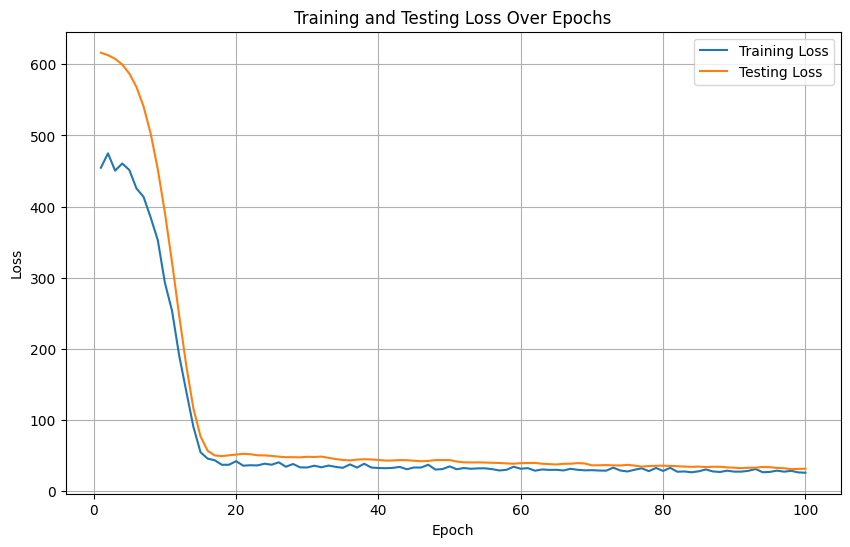

In [24]:
# Plot the training and testing loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [66]:
test_iter = iter(test_loader)


In [67]:
array, label = next(test_iter)
array.shape, label

(torch.Size([2, 30, 30]), tensor([24., 23.]))